# Spotipy - Trial Dataset (Arcy/Megan/Riya)

[**Spotipy**](https://spotipy.readthedocs.io/en/latest/) is a lightweight Python library for the [**Spotify Web API**](https://developer.spotify.com/documentation/web-api/).    
  
With Spotipy you get full access to all of the music data provided by the Spotify platform. 
  
Spotify sample API path: https://open.spotify.com/user/12156070492/playlist/37i9dQZF1DXcuAuT2c9ULm  

Resources:  
https://towardsdatascience.com/making-your-own-discover-weekly-f1ac7546fedb  
https://tgel0.github.io/blog/spotify-data-project-part-1-from-data-retrieval-to-first-insights/  
https://medium.com/deep-learning-turkey/build-your-own-spotify-playlist-of-best-playlist-recommendations-fc9ebe92826a   
https://opendatascience.com/a-machine-learning-deep-dive-into-my-spotify-data/  
https://www.youtube.com/watch?v=v_sPnwoT_iA

In [2]:
import pandas as pd #Dataframe, Series
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

import graphviz
import pydotplus
import io

from scipy import misc

from sklearn.metrics import accuracy_score

import spotipy
import spotipy.util as util
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 

%matplotlib inline

# Spotify Login

- Once you run this it will redirect you to another page, copy the url and paste it into the dialog box that will pop up below.
- If you get a bad request the first time and you logged in, just run it again and use the new link

In [39]:
%env SPOTIPY_CLIENT_ID=a01853bd1d1649f0abf9ccb522657be1
%env SPOTIPY_CLIENT_SECRET=8dd4620bf4a04f2d8db5c7b16e7b77e1
%env SPOTIPY_REDIRECT_URI=https://developer.spotify.com/dashboard/applications/a01853bd1d1649f0abf9ccb522657be1

env: SPOTIPY_CLIENT_ID=a01853bd1d1649f0abf9ccb522657be1
env: SPOTIPY_CLIENT_SECRET=8dd4620bf4a04f2d8db5c7b16e7b77e1
env: SPOTIPY_REDIRECT_URI=https://developer.spotify.com/dashboard/applications/a01853bd1d1649f0abf9ccb522657be1


In [40]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# cid ="3d0813412e904775be1e7513de6ac191" 
# secret = "2f2153031b704871991805855c7a8c52"
# username = "oa66aggjdka7torff2helltk6"

cid ="a01853bd1d1649f0abf9ccb522657be1" 
secret = "8dd4620bf4a04f2d8db5c7b16e7b77e1"
username = ""

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

scope = 'user-library-read playlist-read-private'
token = util.prompt_for_user_token(username, scope)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=a01853bd1d1649f0abf9ccb522657be1&response_type=code&redirect_uri=https%3A%2F%2Fdeveloper.spotify.com%2Fdashboard%2Fapplications%2Fa01853bd1d1649f0abf9ccb522657be1&scope=playlist-read-private+user-library-read in your browser


Enter the URL you were redirected to: https://developer.spotify.com/dashboard/?code=AQDF2V-WvddQJPa1ZkIxc2vUcxKqnadWnLk6s1wdJT8vm4cS5n79ZFBWxBRsaG9dxEfNMl_gyUWa7eTYQ5LiUQg4dbY__Juy0e5wFFmZMkXhlpEqfeocm6i_NEH91_XKcqpFcxFucN4vww1uXjtLuceBCwyy9YXfKFUCRKnxSrz4QMeRFr8Hb5oXMZoZw5Cjx97gdE6jACgoAJOLyXaBPkU804Re9XZWRDQ2p6-AaTztGvv2ugx_m83gPGZkhJEVPd4U-2Ys8kIKIxDagPDO8I99htSDv7rCxyZNwsa2lgDZCmapqHCHxuAYJGYPV0DVwVTr7sw2wQ#!




SpotifyOauthError: Bad Request

# Input Data to the Model
- You need to include the user you want to get the playlist from as well as the playlist id's of your good and bad playlists.
- To do this go to your good and bad playlists and copy the links.
    - An example spotify link: https://open.spotify.com/user/1287242681/playlist/5OdH7PmotfAO7qDGxKdw3J
    - The user is the number after user/ and the playlist id is after the playlist/.

- The method signature is sp.user_playlist('user', 'playlist_id')

In [41]:
# # good_playlist = sp.user_playlist("1287242681", "5OdH7PmotfAO7qDGxKdw3J")
# # bad_playlist = sp.user_playlist("1287242681", "3ySDAXYGUwRrp8C4ejIm9m")

good_playlist = sp.user_playlist("oa66aggjdka7torff2helltk6", "1rArXwbIyQvU31gzc5XHHY?si=6oQTTUWTQ4-xizaDju06ug")
bad_playlist = sp.user_playlist("oa66aggjdka7torff2helltk6", "13bLJeS4U2Drj8SCcwAH24?si=1-aMqHL4ST69DJL1Ho6ZwA")

In [42]:
#Get the good song id's out of the good playlists, need it for the audio features call.
good_tracks = good_playlist["tracks"]
good_songs = good_tracks["items"] 
while good_tracks['next']:
    good_tracks = sp.next(good_tracks)
    for item in good_tracks["items"]:
        good_songs.append(item)
good_ids = [] 
print(len(good_songs))
for i in range(len(good_songs)- 500):
    good_ids.append(good_songs[i]['track']['id'])

743


In [43]:
#Now do the same thing for the bad playlist
bad_tracks = bad_playlist["tracks"]
bad_songs = bad_tracks["items"] 
while bad_tracks['next']:
    bad_tracks = sp.next(bad_tracks)
    for item in bad_tracks["items"]:
        bad_songs.append(item)
bad_ids = [] 
print(len(bad_songs))
for i in range(len(bad_songs)):
    bad_ids.append(bad_songs[i]['track']['id'])

373


In [44]:
#Here is where we get all of the audio_features for the tracks on the good and bad playlists.
features = []
# inSavedTracks = []
j = 0
for i in range(0,len(good_ids),50):
    audio_features = sp.audio_features(good_ids[i:i+50])
    for track in audio_features:
        features.append(track)
        track = good_songs[j]
        j= j+1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['artistPopularity'] = sp.artist(track['track']['artists'][0]['id'])['popularity']
        features[-1]['target'] = 1
j = 0
for i in range(0,len(bad_ids),50):
    audio_features = sp.audio_features(bad_ids[i:i+50])
    for track in audio_features:
        features.append(track)
        track = good_songs[j]
        j= j+1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['artistPopularity'] = sp.artist(track['track']['artists'][0]['id'])['popularity']
        features[-1]['target'] = 0

# Model Training and Data Modeling
- Now that we have the data on what songs you like and don't like let's visualize some of that info.

In [1]:
df = pd.DataFrame(features)
filename = 'riyaSpotify.csv'
df.to_csv(filename, index=False, encoding='utf-8')
trainingData = pd.read_csv("riyaSpotify.csv")
trainingData.head()

NameError: name 'pd' is not defined

- In training this classifier, we need so split our data into training and testing data so our classifier has things to train on and then test if it is right

In [47]:
train, test = train_test_split(trainingData, test_size = 0.15)
print("Training size: {}, Test size: {}".format(len(train),len(test)))

Training size: 523, Test size: 93


In [48]:
# Custom Color Palette for graphs
red_blue = ['#19B5FE', '#EF4836']
palette = sns.color_palette(red_blue)
sns.set_palette(palette)
sns.set_style('white')

# Graphs!!!!!!!

1) First, break out all of the data into positive and negative categories for all the features we want to compare

Also, I know there has to be a better way of doing this, but copy paste is my friend. :)

In [49]:
pos_tempo = trainingData[trainingData['target'] == 1]['tempo']
neg_tempo = trainingData[trainingData['target'] == 0]['tempo']
pos_dance = trainingData[trainingData['target'] == 1]['danceability']
neg_dance = trainingData[trainingData['target'] == 0]['danceability']
pos_duration = trainingData[trainingData['target'] == 1]['duration_ms']
neg_duration = trainingData[trainingData['target'] == 0]['duration_ms']
pos_loudness = trainingData[trainingData['target'] == 1]['loudness']
neg_loudness = trainingData[trainingData['target'] == 0]['loudness']
pos_speechiness = trainingData[trainingData['target'] == 1]['speechiness']
neg_speechiness = trainingData[trainingData['target'] == 0]['speechiness']
pos_valence = trainingData[trainingData['target'] == 1]['valence']
neg_valence = trainingData[trainingData['target'] == 0]['valence']
pos_energy = trainingData[trainingData['target'] == 1]['energy']
neg_energy = trainingData[trainingData['target'] == 0]['energy']
pos_acousticness = trainingData[trainingData['target'] == 1]['acousticness']
neg_acousticness = trainingData[trainingData['target'] == 0]['acousticness']
pos_key = trainingData[trainingData['target'] == 1]['key']
neg_key = trainingData[trainingData['target'] == 0]['key']
pos_instrumentalness = trainingData[trainingData['target'] == 1]['instrumentalness']
neg_instrumentalness = trainingData[trainingData['target'] == 0]['instrumentalness']
pos_popularity = trainingData[trainingData['target'] == 1]['trackPopularity']
neg_popularity = trainingData[trainingData['target'] == 0]['trackPopularity']

In [50]:
print(pos_popularity)
print(neg_popularity)

0      63
1      69
2      67
3      64
4      24
5      47
6      68
7      14
8      63
9      62
10     55
11     41
12     24
13     69
14     56
15     54
16     17
17     45
18     28
19     56
20     63
21     44
22     55
23     17
24     71
25     62
26     58
27     56
28     13
29     52
       ..
213    69
214    65
215    64
216    22
217    55
218    25
219    75
220     1
221    78
222     0
223    39
224    41
225    55
226    42
227    61
228    73
229    60
230    70
231    16
232    51
233    71
234    26
235    57
236    56
237    70
238    46
239    54
240     7
241     0
242    37
Name: trackPopularity, Length: 243, dtype: int64
243    63
244    69
245    67
246    64
247    24
248    47
249    68
250    14
251    63
252    62
253    55
254    41
255    24
256    69
257    56
258    54
259    17
260    45
261    28
262    56
263    63
264    44
265    55
266    17
267    71
268    62
269    58
270    56
271    13
272    52
       ..
586    49
587    75
588    65
5

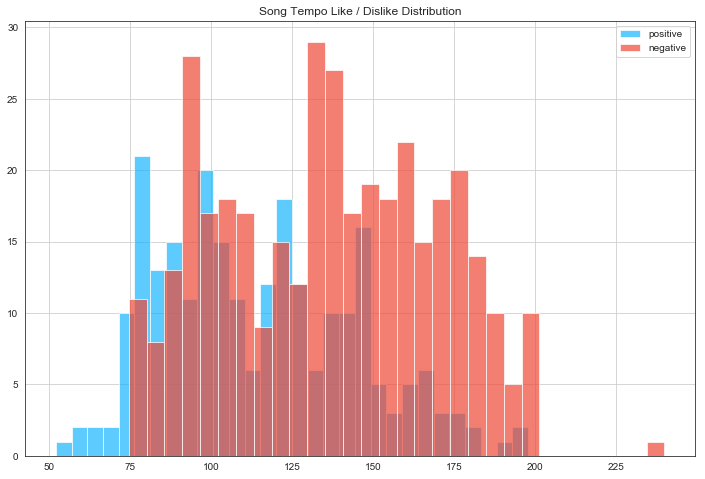

In [51]:
fig = plt.figure(figsize=(12,8))
plt.title("Song Tempo Like / Dislike Distribution")
pos_tempo.hist(alpha=0.7, bins=30, label='positive')
neg_tempo.hist(alpha=0.7, bins=30, label='negative')
plt.legend(loc='upper right')

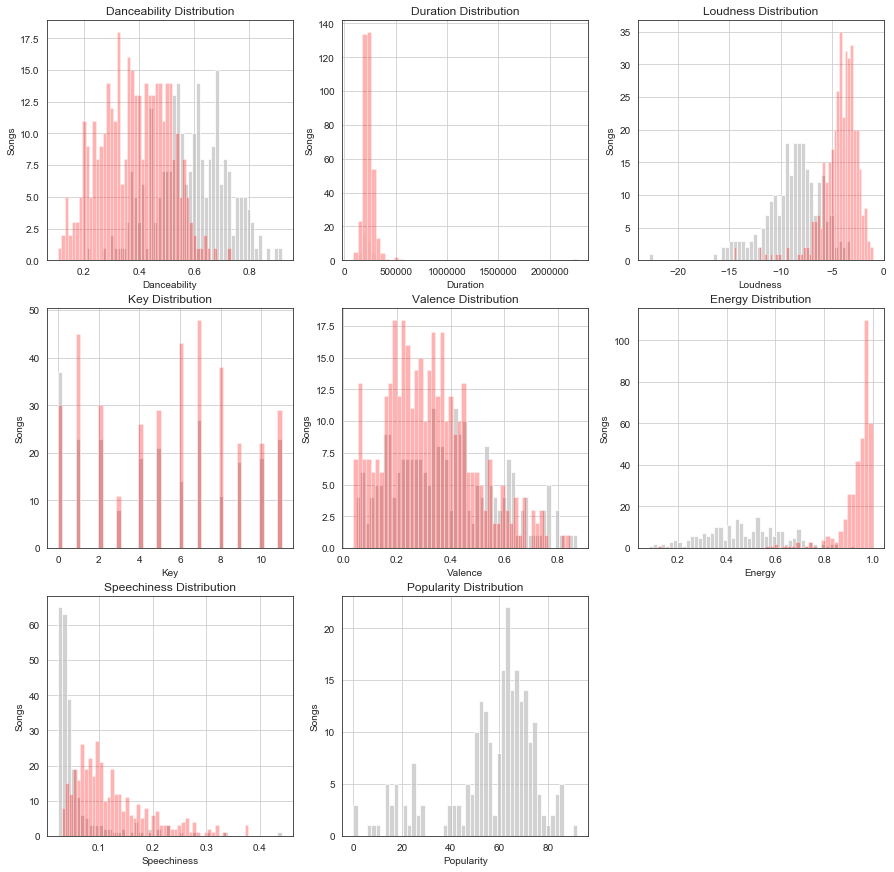

In [52]:
fig2 = plt.figure(figsize=(15,15))

#Danceability
ax3 = fig2.add_subplot(331)
ax3.set_xlabel('Danceability')
ax3.set_ylabel('Songs')
ax3.set_title('Danceability Distribution')
pos_dance.hist(alpha= 0.7, bins=50, color='0.75')
ax4 = fig2.add_subplot(331)
neg_dance.hist(alpha= 0.3, bins=50, color='r')

#Duration_ms
ax5 = fig2.add_subplot(332)
ax5.set_xlabel('Duration')
ax5.set_ylabel('Songs')
ax5.set_title('Duration Distribution')
pos_duration.hist(alpha= 0.7, bins=50, color='0.75')
ax6 = fig2.add_subplot(332)
neg_duration.hist(alpha= 0.3, bins=50, color='r')

#Loudness
ax7 = fig2.add_subplot(333)
ax7.set_xlabel('Loudness')
ax7.set_ylabel('Songs')
ax7.set_title('Loudness Distribution')
pos_loudness.hist(alpha= 0.7, bins=50, color='0.75')
ax8 = fig2.add_subplot(333)
neg_loudness.hist(alpha= 0.3, bins=50, color='r')

#Key
ax9 = fig2.add_subplot(334)
ax9.set_xlabel('Key')
ax9.set_ylabel('Songs')
ax9.set_title('Key Distribution')
pos_key.hist(alpha= 0.7, bins=50, color='0.75')
ax10 = fig2.add_subplot(334)
neg_key.hist(alpha= 0.3, bins=50, color='r')

#Valence
ax11 = fig2.add_subplot(335)
ax11.set_xlabel('Valence')
ax11.set_ylabel('Songs')
ax11.set_title('Valence Distribution')
pos_valence.hist(alpha= 0.7, bins=50, color='0.75')
ax12 = fig2.add_subplot(335)
neg_valence.hist(alpha= 0.3, bins=50, color='r')

#Energy
ax13 = fig2.add_subplot(336)
ax13.set_xlabel('Energy')
ax13.set_ylabel('Songs')
ax13.set_title('Energy Distribution')
pos_energy.hist(alpha= 0.7, bins=50, color='0.75')
ax14 = fig2.add_subplot(336)
neg_energy.hist(alpha= 0.3, bins=50, color='r')

#Speechiness
ax15 = fig2.add_subplot(337)
ax15.set_xlabel('Speechiness')
ax15.set_ylabel('Songs')
ax15.set_title('Speechiness Distribution')
pos_speechiness.hist(alpha= 0.7, bins=50, color='0.75')
ax16 = fig2.add_subplot(337)
neg_speechiness.hist(alpha= 0.3, bins=50, color='r')

#Popularity
ax15 = fig2.add_subplot(338)
ax15.set_xlabel('Popularity')
ax15.set_ylabel('Songs')
ax15.set_title('Popularity Distribution')
pos_popularity.hist(alpha= 0.7, bins=50, color='0.75')
ax16 = fig2.add_subplot(338)
# neg_popularity.hist(alpha= 0.3, bins=50, color='r')

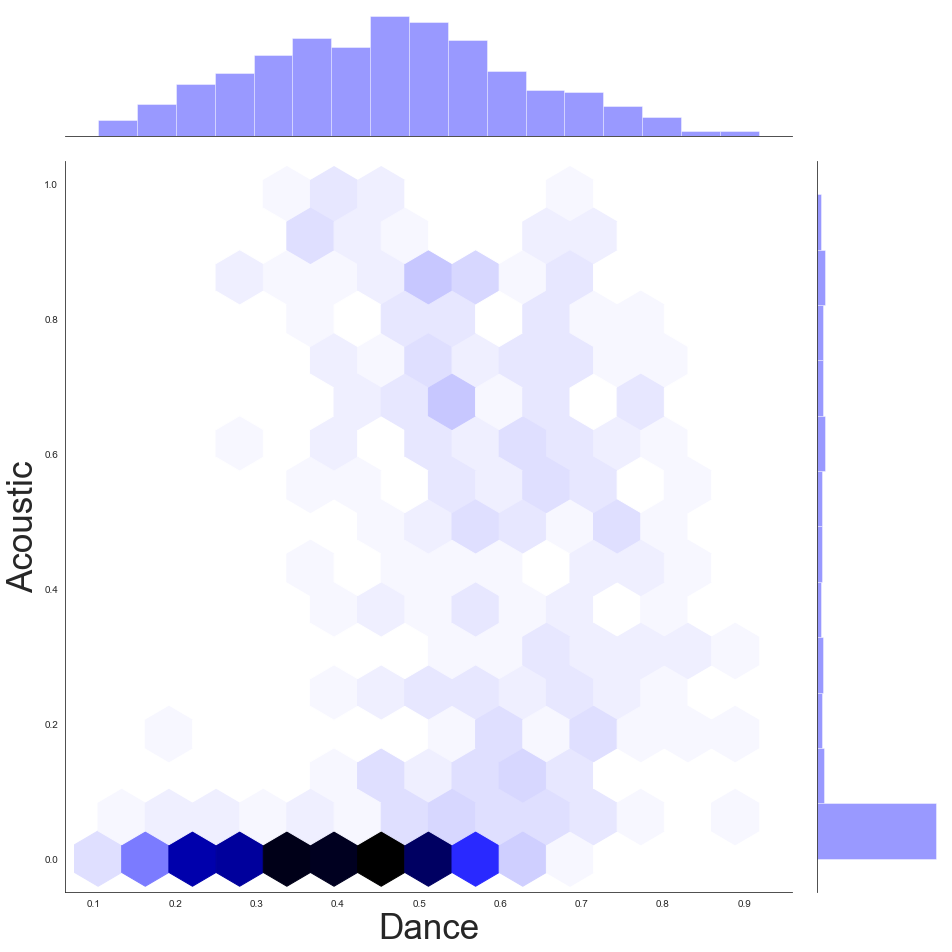

In [54]:
plt.rc("legend", fontsize=35)
#sns.jointplot(y=df['ENERGY'], x=df['LOUD'], kind="hex", color="r", size=13).set_axis_labels("Loudness", "Energy", fontsize=35)
#sns.jointplot(y=df['ENERGY'], x=df['ACOUSTIC'], kind="hex", color="r", size=13).set_axis_labels("Acousticness", "Energy", fontsize=35)
#sns.jointplot(y=df['DANCE'], x=df['VALENCE'], kind="hex", color="r", size=13).set_axis_labels("Valence (positive mood)", "Danceability", fontsize=35)
#sns.jointplot(y=df['ACOUSTIC'], x=df['LOUD'], kind="hex", color="r", size=13).set_axis_labels("Loudness", "Acousticness", fontsize=35)
#sns.jointplot(y=df['ENERGY'], x=df['VALENCE'], kind="hex", color="r", size=13).set_axis_labels("Valence (positive mood)", "Energy", fontsize=35)
#sns.jointplot(y=df['POP.'], x=df['ENERGY'], kind="hex", color="r", size=13).set_axis_labels("Energy", "Popularity", fontsize=35)
sns.jointplot(y=trainingData['acousticness'], x=trainingData['danceability'], kind="hex", color="b", height=13).set_axis_labels("Dance", "Acoustic", fontsize=35)

# Whew, now that we have graphs galore, lets actually get into some different classifiers and see how they preform!

In [55]:
#Define the set of features that we want to look at
features = ["danceability", "loudness", "valence", "energy", "instrumentalness", "acousticness", "key", "speechiness","duration_ms"]

In [56]:
#Split the data into x and y test and train sets to feed them into a bunch of classifiers!
x_train = train[features]
y_train = train["target"]

x_test = test[features]
y_test = test["target"]

1) A Decision Tree Classifier
- A decision tree classifier is often the easiest to visualize, so we will start with it first
- All it is is pretty much a decision tree based off the features so you can trace the path down and visually see how it makes decisions. This is nice to visualize but it isn't all that good at predicting this data.

In [57]:
c = DecisionTreeClassifier(min_samples_split=100)
dt = c.fit(x_train, y_train)

In [ ]:
# def show_tree(InputTree, features, path):
#     f = io.StringIO()
#     tree.export_graphviz(InputTree, out_file=f, feature_names=features)
#     pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
#     img = misc.imread(path)
#     plt.rcParams["figure.figsize"] = (20,20)
#     plt.imshow(img)
# show_tree(dt, features, "dec_tree.png")

This is how we will see how our different classifiers do, by predicting the results on the test data and then figuring out how well they did.

In [58]:
y_pred = c.predict(x_test)
score = accuracy_score(y_test, y_pred) * 100
print("Accuracy using Decision Tree: ", round(score, 1), "%")

Accuracy using Decision Tree:  95.7 %


# A Bunch More Classifier Models
- There are some of these that take a bunch of time to finish, I wouldnt recommend running all them unless you are really intrested in the results

## The ones that take less time

In [59]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(3)
knn.fit(x_train, y_train)
knn_pred = c.predict(x_test)
score = accuracy_score(y_test, knn_pred) * 100
print("Accuracy using Knn Tree: ", round(score, 1), "%")

Accuracy using Knn Tree:  95.7 %


In [60]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train, y_train)
mlp_pred = mlp.predict(x_test)
score = accuracy_score(y_test, mlp_pred) * 100
print("Accuracy using mlp Tree: ", round(score, 1), "%")

Accuracy using mlp Tree:  53.8 %


In [61]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
forest.fit(x_train, y_train)
forest_pred = forest.predict(x_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, forest_pred) * 100
print("Accuracy using random forest: ", round(score, 1), "%")

Accuracy using random forest:  95.7 %


In [62]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(x_train, y_train)
ada_pred = ada.predict(x_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, ada_pred) * 100
print("Accuracy using ada: ", round(score, 1), "%")

Accuracy using ada:  98.9 %


In [63]:
from sklearn.naive_bayes import GaussianNB
gauss = GaussianNB()
gauss.fit(x_train, y_train)
gauss_pred = gauss.predict(x_test)
score = accuracy_score(y_test, gauss_pred)*100
print("Accuracy using gauss: ", round(score, 1), "%")

Accuracy using gauss:  83.9 %


In [64]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3, random_state=0)
k_means.fit(x_train, y_train)
predicted= k_means.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Kmeans: ", round(score, 1), "%")

Accuracy using Kmeans:  19.4 %


In [65]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.1, max_depth=1, random_state=0)
gbc.fit(x_train, y_train)
predicted = gbc.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Gbc: ", round(score, 1), "%")

Accuracy using Gbc:  97.8 %


In [66]:
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier()
bc.fit(x_train, y_train)
predicted = bc.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using bc: ", round(score, 1), "%")

Accuracy using bc:  95.7 %


In [67]:
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

clf1 = GradientBoostingClassifier(learning_rate=0.2, max_depth=10, n_estimators=300)
clf2 = BaggingClassifier(n_estimators=100)
# lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2]
                          , meta_classifier=clf1
                          , use_probas=True
                          , average_probas=False,)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, sclf], 
                      ['GBC', 
                       'BC',
                       'StackingClassifier']):

    scores = cross_val_score(clf, x_train, y_train, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.97 (+/- 0.00) [GBC]
Accuracy: 0.98 (+/- 0.00) [BC]
Accuracy: 0.97 (+/- 0.00) [StackingClassifier]


## The ones that take more time

In [ ]:
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# qda = QuadraticDiscriminantAnalysis()
# qda.fit(x_train, y_train)
# qda_pred = qda.predict(x_test)
# score = accuracy_score(y_test, qda_pred)*100
# print("Accuracy using qda: ", round(score, 1), "%")

In [ ]:
# from sklearn.svm import SVC
# svc_lin = SVC(kernel="linear", C=0.025)
# svc_lin.fit(x_train, y_train)
# svc_pred = svc_lin.predict(x_test)
# from sklearn.metrics import accuracy_score
# score = accuracy_score(y_test, svc_pred) * 100
# print("Accuracy using svc linear: ", round(score, 1), "%")

In [ ]:
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# gpc = GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True)
# gpc.fit(x_train, y_train)
# gpc_pred = gpc.predict(x_test)
# from sklearn.metrics import accuracy_score
# score = accuracy_score(y_test, gpc_pred) * 100
# print("Accuracy using gpc: ", round(score, 1), "%")

# Now we should have a classifier with the highest accuracy score

In [ ]:
# Request to modify playlists
username = "1287242681"
scope = 'playlist-modify-private playlist-modify-public playlist-read-private user-library-read'
token = util.prompt_for_user_token(username, scope)
#Good Playlist
if token:
    sp = spotipy.Spotify(auth=token)

## Now we need to pick a playlist you want you classifier to find songs you like in...
- Use the same thing you used to find the good and bad playlists to specify this new playlist you've taken an intrest in.

In [ ]:
playlistToFindSongsYouLikeIn = sp.user_playlist("spotify", "37i9dQZEVXcFqDuJHHirGk")

newPlaylist_tracks = playlistToFindSongsYouLikeIn["tracks"]
newPlaylist_songs = newPlaylist_tracks["items"] 
while newPlaylist_tracks['next']:
    newPlaylist_tracks = sp.next(newPlaylist_tracks)
    for song in newPlaylist_tracks["items"]:
        newPlaylist_songs.append(song)
        
newPlaylist_song_ids = [] 
print(len(newPlaylist_songs))
for i in range(len(newPlaylist_songs)):
    newPlaylist_song_ids.append(newPlaylist_songs[i]['track']['id'])
    
newPlaylist_features = []
j = 0
for i in range(0,len(newPlaylist_song_ids),50):
    audio_features = sp.audio_features(newPlaylist_song_ids[i:i+50])
    for track in audio_features:
        track['song_title'] = newPlaylist_songs[j]['track']['name']
        track['artist'] = newPlaylist_songs[j]['track']['artists'][0]['name']
        j= j + 1
        newPlaylist_features.append(track)
print(len(newPlaylist_features))

playlistToLookAtFeatures = pd.DataFrame(newPlaylist_features)

# We just loaded in your new tracks and audio features for those tracks
- Now all we have to do is find the highest accuracy value out of all you classifiers (for me it was gdc) and predict what we will have over the new playlist

### Quick aside: you can put these into a new playlist as well, just use the sp.user_playlist_add_tracks function
- The function looks like this user_playlist_add_tracks("username", "playlist_id", "track_id_to_add")

In [ ]:
pred = gbc.predict(playlistToLookAtFeatures[features])

likedSongs = 0
i = 0
for prediction in pred:
    if(prediction == 1):
        print ("Song: " + playlistToLookAtFeatures["song_title"][i] + ", By: "+ playlistToLookAtFeatures["artist"][i])
        #sp.user_playlist_add_tracks("1287242681", "7eIX1zvtpZR3M3rYFVA7DF", [test['id'][i]])
        likedSongs= likedSongs + 1
    i = i +1
    

# There Ya Go!
- This was my quick overview of my process of how I used classifiers and spoitfy to try and help me find tracks I might like in any playlist on spotify!
- I want to make this tutorial less involved and figure out a way to make my classifiers better as well as using Tensorflow to make a model in order to do this for me.

# Tuning using GridSearchCV

## I. GradientBoostingClassifier

In [68]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [69]:
estimator = Pipeline([("imputer", SimpleImputer(strategy='mean'))
                      , ('standardizer', StandardScaler())
                      , ("gbm", GradientBoostingClassifier())
                     ])

parameters = {'gbm__n_estimators': [50, 100, 300]
              , 'gbm__max_depth' : [8, 10, 12]
              , 'gbm__learning_rate' : [0.1, 0.2, 0.7]
             }

In [70]:
gs = GridSearchCV(estimator, parameters, cv=3, verbose=3, scoring='roc_auc', n_jobs=1)

In [71]:
gs.fit(x_train, y_train.values.ravel())

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=50 ..
[CV]  gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=50, score=0.9809286898839138, total=   0.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=50 ..
[CV]  gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=50, score=0.9344941956882257, total=   0.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=50 ..
[CV]  gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=50, score=0.9614839988671764, total=   0.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=100 .
[CV]  gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=100, score=0.9982725262576009, total=   0.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=100 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=100, score=0.9957158651188501, total=   0.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=100 .
[CV]  gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=100, score=0.9820164259416596, total=   0.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=300 .
[CV]  gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=300, score=0.9981343283582089, total=   0.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=300 .
[CV]  gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=300, score=0.9958540630182422, total=   0.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=300 .
[CV]  gbm__learning_rate=0.1, gbm__max_depth=8, gbm__n_estimators=300, score=0.9817332200509771, total=   0.0s
[CV] gbm__learning_rate=0.1, gbm__max_depth=10, gbm__n_estimators=50 .
[CV]  gbm__learning_rate=0.1, gbm__max_depth=10, gbm__n_estimators=50, score=0.98092868988

[CV]  gbm__learning_rate=0.2, gbm__max_depth=12, gbm__n_estimators=100, score=0.9948175787728026, total=   0.0s
[CV] gbm__learning_rate=0.2, gbm__max_depth=12, gbm__n_estimators=100 
[CV]  gbm__learning_rate=0.2, gbm__max_depth=12, gbm__n_estimators=100, score=0.9822996318323421, total=   0.0s
[CV] gbm__learning_rate=0.2, gbm__max_depth=12, gbm__n_estimators=300 
[CV]  gbm__learning_rate=0.2, gbm__max_depth=12, gbm__n_estimators=300, score=0.9972360420121613, total=   0.0s
[CV] gbm__learning_rate=0.2, gbm__max_depth=12, gbm__n_estimators=300 
[CV]  gbm__learning_rate=0.2, gbm__max_depth=12, gbm__n_estimators=300, score=0.9948175787728026, total=   0.0s
[CV] gbm__learning_rate=0.2, gbm__max_depth=12, gbm__n_estimators=300 
[CV]  gbm__learning_rate=0.2, gbm__max_depth=12, gbm__n_estimators=300, score=0.9815916171056358, total=   0.0s
[CV] gbm__learning_rate=0.7, gbm__max_depth=8, gbm__n_estimators=50 ..
[CV]  gbm__learning_rate=0.7, gbm__max_depth=8, gbm__n_estimators=50, score=0.9849364

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    3.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, l...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'gbm__n_estimators': [50, 100, 300], 'gbm__max_depth': [8, 10, 12], 'gbm__learning_rate': [0.1, 0.2, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [72]:
gs.best_params_

{'gbm__learning_rate': 0.1, 'gbm__max_depth': 12, 'gbm__n_estimators': 100}

In [73]:
tuned_estimator = Pipeline([("imputer", SimpleImputer(strategy='mean'))
                      , ('standardizer', StandardScaler())
                      , ("gbm", GradientBoostingClassifier(learning_rate=0.1
                                                          , max_depth=12
                                                          , n_estimators=100))
                     ])

tuned_estimator.fit(x_train, y_train.values.ravel())

Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, l...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [74]:
predicted = tuned_estimator.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Tuned GBC: ", round(score, 1), "%")

Accuracy using Tuned GBC:  97.8 %


## II. BaggingClassifier

In [75]:
estimator = Pipeline([("imputer", SimpleImputer(strategy='mean'))
                      , ('standardizer', StandardScaler())
                      , ("bc", BaggingClassifier())
                     ])

parameters = {'bc__n_estimators': [50, 100, 300]}

In [76]:
gs = GridSearchCV(estimator, parameters, cv=3, verbose=3, scoring='roc_auc', n_jobs=1)

In [77]:
gs.fit(x_train, y_train.values.ravel())

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] bc__n_estimators=50 .............................................
[CV] .... bc__n_estimators=50, score=0.9982725262576009, total=   0.0s
[CV] bc__n_estimators=50 .............................................
[CV] ..... bc__n_estimators=50, score=0.996199557766722, total=   0.0s
[CV] bc__n_estimators=50 .............................................
[CV] .... bc__n_estimators=50, score=0.9815916171056358, total=   0.0s
[CV] bc__n_estimators=100 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .... bc__n_estimators=100, score=0.993988391376451, total=   0.0s
[CV] bc__n_estimators=100 ............................................
[CV] ... bc__n_estimators=100, score=0.9959231619679381, total=   0.0s
[CV] bc__n_estimators=100 ............................................
[CV] ... bc__n_estimators=100, score=0.9882469555366752, total=   0.0s
[CV] bc__n_estimators=300 ............................................
[CV] ... bc__n_estimators=300, score=0.9977888336097291, total=   0.2s
[CV] bc__n_estimators=300 ............................................
[CV] .... bc__n_estimators=300, score=0.995992260917634, total=   0.2s
[CV] bc__n_estimators=300 ............................................
[CV] .... bc__n_estimators=300, score=0.994052676295667, total=   0.2s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('bc', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'bc__n_estimators': [50, 100, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [78]:
gs.best_params_

{'bc__n_estimators': 300}

In [79]:
tuned_estimator = Pipeline([("imputer", SimpleImputer(strategy='mean'))
                      , ('standardizer', StandardScaler())
                      , ("bc", BaggingClassifier(n_estimators=300))
                     ])

tuned_estimator.fit(x_train, y_train.values.ravel())

Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('bc', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=300, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False))])

In [80]:
predicted = tuned_estimator.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Tuned BC: ", round(score, 1), "%")

Accuracy using Tuned BC:  97.8 %
